# Imports

In [30]:
import os
from functools import partial
import json
import csv

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import random

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [ ]:
newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")

# Downloading state data

In [13]:
graph_path = "./texas.json"
graph = Graph.from_json(graph_path)

# Chain stuff

In [38]:
election = "SEN12"

In [15]:
pop_count = 0

for i in graph.nodes:
    pop_count += graph.nodes[i]["TOTPOP"]
    
print(pop_count)

25145561.0


In [16]:
for n in graph.nodes:
    graph.nodes[n][election+"D"] = int(graph.nodes[n][election+"D"].replace(",",""))
    graph.nodes[n][election+"R"] = int(graph.nodes[n][election+"R"].replace(",",""))

AttributeError: 'int' object has no attribute 'replace'

In [17]:
graph.nodes[0]

{'boundary_node': False,
 'area': 5616315.599709552,
 'CNTYVTD': '10001',
 'VTD': '0001',
 'WHITE': 2053.0,
 'OTHER': 89.0,
 'HISPANIC': 401.0,
 'TOTPOP': 3131.0,
 'VAP': 2341.0,
 'BLACK': 606.0,
 'BLKHISP': 989.0,
 'WVAP': 1677.0,
 'HISPVAP': 217.0,
 'BHVAP': 592.0,
 'BVAP': 378.0,
 'OTHVAP': 72.0,
 'COUNTY': 'Anderson',
 'FIPS': 1,
 'PRES12R': 754,
 'PRES12D': 261,
 'SEN12R': 713,
 'SEN12D': 285,
 'TOTVR12': 1629,
 'TOTTO12': 1026,
 'SEN14R': 441,
 'SEN14D': 110,
 'GOV14R': 424,
 'GOV14D': 130,
 'TOTVR14': 1712,
 'TOTTO14': 576,
 'PRES16D': 262,
 'PRES16R': 742,
 'TOTVR16': 1799,
 'TOTTO16': 1030,
 'USCD': '05',
 'SEND': 3,
 'HD': 8,
 'AREA': 6,
 'PERIM': 15}

In [47]:
%%time
num_dist = 36

# Exercise: Compute exact population from your data.
pop = pop_count

my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    election: Election(election, {"republican": election+"R", "democratic":election+"D"})
}


new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "TOTPOP",
                               0.001,
                               3)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

Wall time: 1min 31s


In [48]:
%%time
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.001,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

Wall time: 70.9 ms


# Pulling data from chain run

In [ ]:
%%time
pop_bound = 0.01
num_steps = 50000

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, pop_bound),
        compactness_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=num_steps,
)

data = []
t = 0

with open(newdir + "texas_data_specs.txt", "w") as f:
    f.write("population bound: ")
    f.write(str(pop_bound))
    f.write(", number of steps: ")
    f.write(str(num_steps))

for step in tqdm_notebook(chain):
    data.append([step[election].wins("republican"),
                         mean_median(step[election]),
                         partisan_gini(step[election]),
                         step[election].percents("republican")])
    t += 1
    if t % 5000 == 0:
        with open(newdir + "texas_data" + str(t) + ".csv", "w") as f:
            writer = csv.writer(f, lineterminator="\n")
            writer.writerows(data)

# Visualization


Wall time: 136 ms


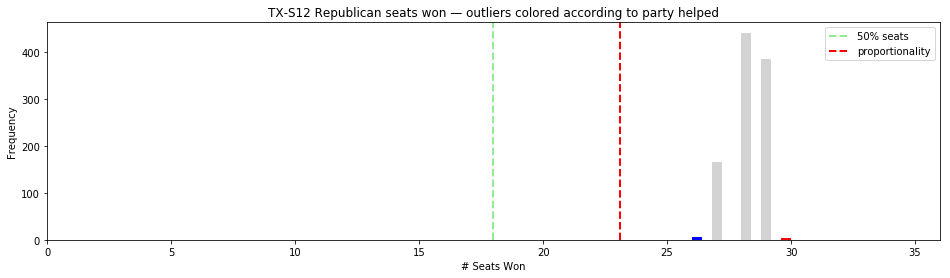

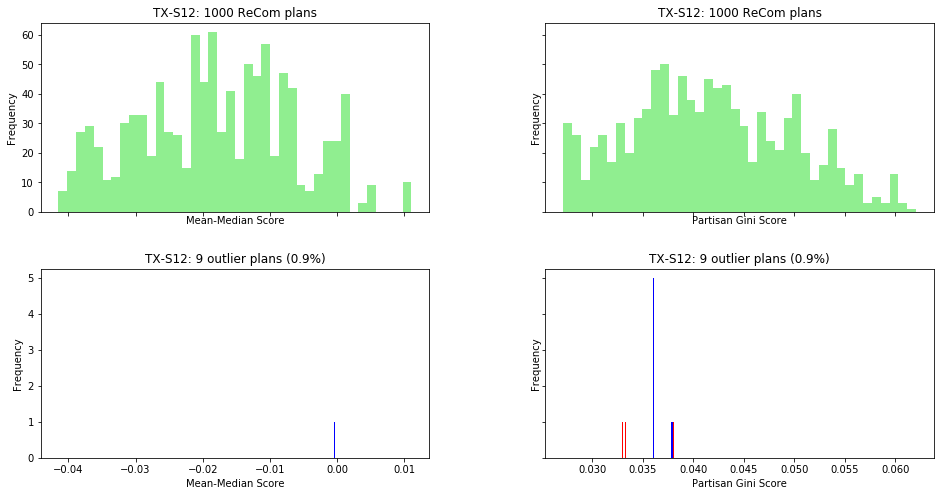

In [26]:
%%time
# fig, votes = plt.subplots(figsize=(16,4))
fig, seats = plt.subplots(figsize=(16,4))
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Variables
inliers = [27,29]
bins_num = 20
out_bins_num = 10
title = "TX-S12: 1000 ReCom plans"

# Colors
seats_colors = ["red", "blue", "lightgray"]
party_colors = ["red", "blue"]
neutral = "lightgreen"

# Creating Datasets
mm = []
pg = []
vs = []
mm_routliers = []
mm_doutliers = []
pg_routliers = []
pg_doutliers = []
seats_routliers = []
seats_doutliers = []
seats_inliers = []
vs_routliers = []
vs_doutliers = []


for plan in tqdm_notebook(data):
    mm.append(plan[1])
    pg.append(plan[2])
    vs.append(plan[3])
    if plan[0] < inliers[0]:
        seats_doutliers.append(plan[0])
        mm_doutliers.append(plan[1])
        pg_doutliers.append(plan[2])
        vs_doutliers.append(plan[3])
    if plan[0] > inliers[1]:
        seats_routliers.append(plan[0])
        mm_routliers.append(plan[1])
        pg_routliers.append(plan[2])
        vs_routliers.append(plan[3])
    if plan[0] >= inliers[0] and plan[0] <= inliers[1]:
        seats_inliers.append(plan[0])

mms = [mm_routliers, mm_doutliers]
pgs = [pg_routliers, pg_doutliers]
seats_colored = [seats_routliers, seats_doutliers, seats_inliers]

# More variables
num_outliers = str(len(mm_doutliers) + len(mm_routliers))
pct_outliers = str(round((len(mm_doutliers) + len(mm_routliers)) / 1000 * 100, 1))
title_w = "TX-S12: " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"

# Plotting the votes shares boxplots
# votes.boxplot(vs, positions=range(len(data.columns)))

# votes.set_title("Votes Shares Boxplots")
# votes.set_ylabel("Republican Votes %")
# votes.set_xlabel("District #")


# Plotting the seats histogram
seats.hist(seats_colored, bins=out_bins_num, stacked=True, color=seats_colors)

seats.set_title("TX-S12 Republican seats won — outliers colored according to party helped")
seats.set_ylabel("Frequency")
seats.set_xlabel("# Seats Won")
seats.set_xlim(0, num_dist)
seats.axvline(x = num_dist/2, color=neutral, linestyle="dashed", linewidth=2, label="50% seats")
seats.axvline(x = num_dist * initial_partition[election].percent("republican"), color="red", linestyle="dashed", linewidth=2, label="proportionality")
seats.legend()
# seats.set_xticks(1)

# Plotting the whole dataset
ax[0,0].hist(mm, bins=2*bins_num, color=neutral)
ax[0,1].hist(pg, bins=2*bins_num, color=neutral)

ax[0,0].set_title(title)
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("Mean-Median Score")

ax[0,1].set_title(title)
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_xlabel("Partisan Gini Score")

# Plotting the winnowed data
ax[1,0].hist(mms, bins=bins_num, color=party_colors)
ax[1,1].hist(pgs, bins=bins_num, color=party_colors)
# ax[1,1].set_ylim((0,40))

ax[1,0].set_title(title_w)
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlabel("Mean-Median Score")

ax[1,1].set_title(title_w)
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_xlabel("Partisan Gini Score")